In [15]:
import pandas as pd
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")


df = pd.read_csv('processed_data.csv')

df_majority = df[df['Privacy Exists']==0]
df_minority = df[df['Privacy Exists']==1]
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=2750,     # to match minority class
                                 random_state=123) # reproducible results
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

X = df_downsampled.iloc[:, 1:-1].values
Y = df_downsampled.iloc[:, -1:].values


scaler = StandardScaler(); X = scaler.fit_transform(X)

X_new = SelectKBest(f_classif, k=80).fit_transform(X, Y)

X_train, X_test, y_train, y_test = train_test_split(X_new, Y, test_size=0.3, random_state = 5)

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=150, max_depth = 120),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Neural Networks': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000),
    'SVM' : SVC(kernel = "poly", degree = 3, coef0=1, C=5)
}

rf_Model = RandomForestClassifier()

In [21]:
# Number of trees in random forest
n_estimators = list(range(120,150,10))
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = list(range(100,130,10))
# Minimum number of samples required to split a node
min_samples_split = list(range(6,10,2))
# Minimum number of samples required at each leaf node
min_samples_leaf = range(1,5,1)
# Method of selecting samples for training each tree
bootstrap = [True, False]


param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [22]:
from sklearn.model_selection import GridSearchCV
rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 3, verbose=2, n_jobs = 4)
rf_Grid.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [100, 110, 120],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': [6, 8],
                         'n_estimators': [120, 130, 140]},
             verbose=2)

In [23]:
rf_Grid.best_params_

{'bootstrap': False,
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 6,
 'n_estimators': 130}

In [27]:
from sklearn.model_selection import cross_val_score

print (f'Train Accuracy - : {rf_Grid.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : {rf_Grid.score(X_test,y_test):.3f}')



Train Accuracy - : 0.967
Test Accuracy - : 0.703


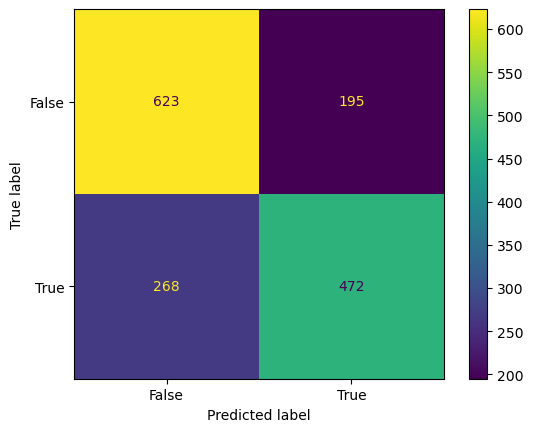

<Figure size 640x480 with 0 Axes>

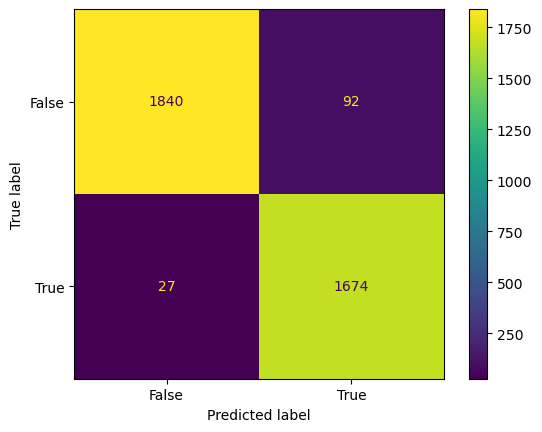

In [31]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred_train = rf_Grid.predict(X_train)
y_pred_test = rf_Grid.predict(X_test)

confusion_matrix_test = confusion_matrix(y_test, y_pred_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_test, display_labels = [False, True])
cm_display.plot()
plt.show()
plt.figure()

confusion_matrix_train = confusion_matrix(y_train, y_pred_train)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_train, display_labels = [False, True])
cm_display.plot()
plt.show()
